In [1]:
%matplotlib notebook

import sys
import os
import numpy as np
import cv2
sys.path.append("./utils/") # Adds higher directory to python modules path.
import loadcoraldata_utils as coralutils
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from NeMO_losses import charbonnierLoss
import NeMO_layers
from keras.models import Model, Sequential, load_model
from scipy.misc import imresize
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from metrics import metrics
import json

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%matplotlib notebook

model = load_model('./tmp/RefineMask_Jarrett256_RGB_NIR3.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})
SRmodel = load_model('./tmp/SR_FeatureWise.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 
                                                    'charbonnierLoss': charbonnierLoss})
# Cloudmodel = load_model('./tmp/RefineMask_Cloud.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D,'charbonnierLoss': charbonnierLoss})

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


(3823, 8941, 4)
6314.0


<IPython.core.display.Javascript object>


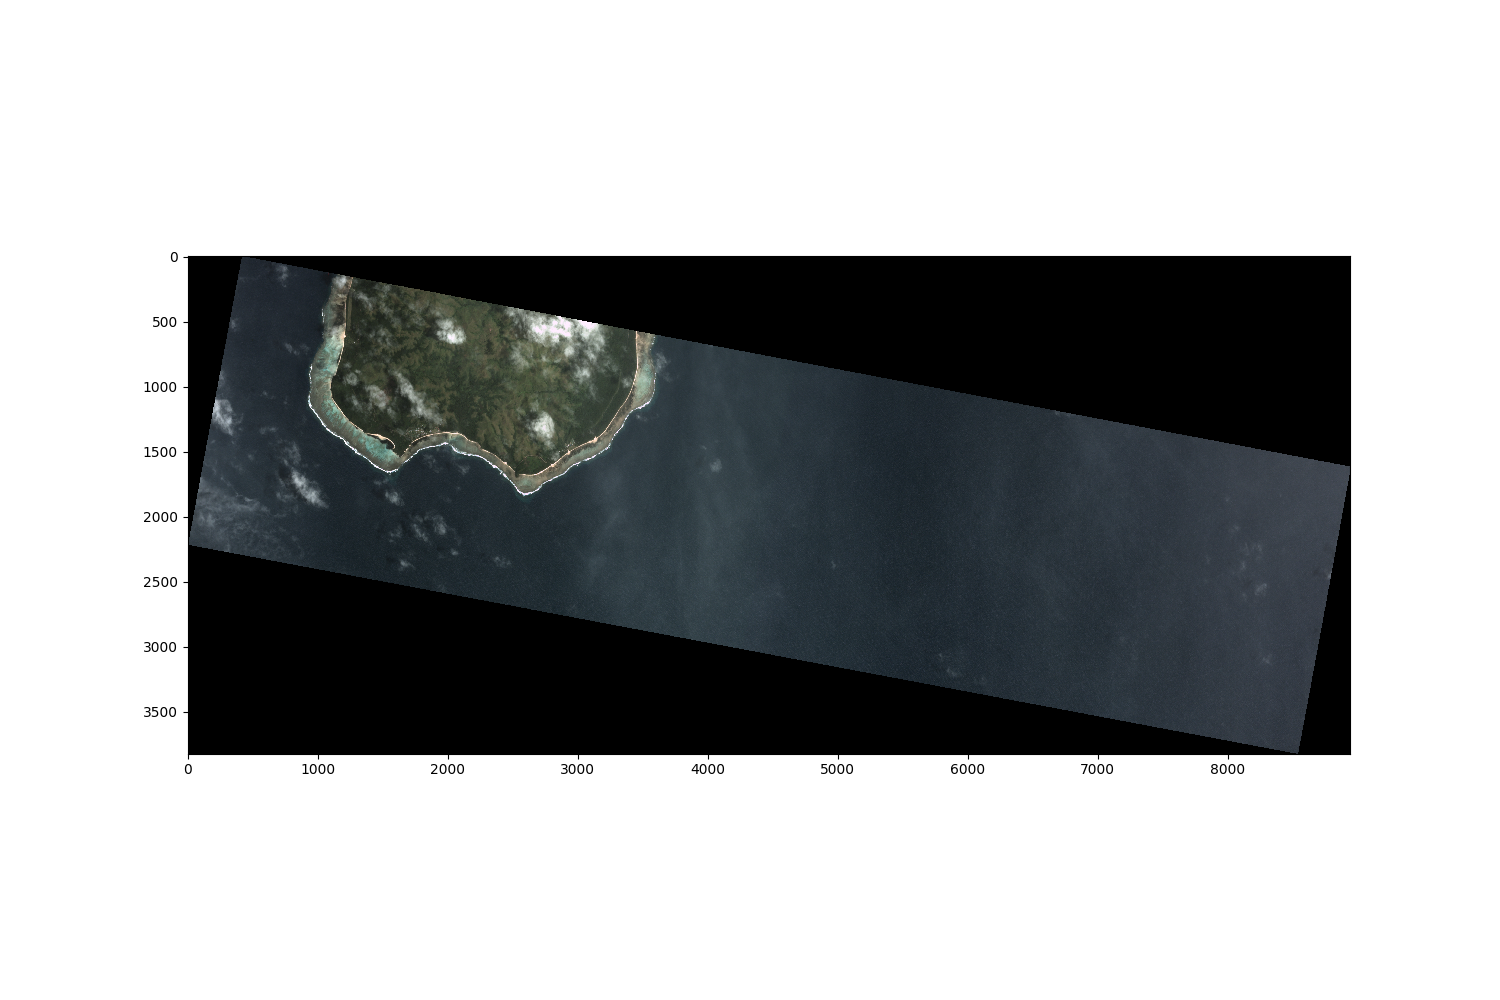

In [3]:
img = coralutils.CoralData("/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_336801/20181216_214344_0f35/20181216_214344_0f35_3B_AnalyticMS_SR.tif", load_type="raster")
jsonpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_336801/20181216_214344_0f35/20181216_214344_0f35_metadata.json"
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
    
print(img.image.shape)
img.truthimage = np.zeros(img.image.shape)
print(np.max(img.image))
# print(json_data)

def fixRGBimg(img,pixel_mean,pixel_std,minval,maxval):
    fixed_img = np.copy(img)
    if type(pixel_std) == list:
        for i,std in enumerate(pixel_std):
            fixed_img[:,:,i] = fixed_img[:,:,i]*std+pixel_mean
    else:
        fixed_img = fixed_img*pixel_std+pixel_mean
    fixed_img[fixed_img > maxval] = maxval
    fixed_img[fixed_img < minval] = minval
    fixed_img = np.asarray(fixed_img, dtype=np.uint8)
    return fixed_img

fixed_img = fixRGBimg(img.image,0,255/3000,0,255) # turn into 0-255

fig = plt.figure(1, figsize=(15,10))
pic = np.rollaxis(np.asarray([fixed_img[:,:,2], fixed_img[:,:,1], fixed_img[:,:,0]]),0,3)
pic = np.asarray(pic, dtype=np.uint8)
plt.imshow(pic)
plt.show()
    

In [4]:
# Extra step for SR Featurewise model
# SRmodel.summary()
Input = SRmodel.get_layer("model_1").get_input_at(0)
SR_layer = SRmodel.get_layer("model_1").get_output_at(0)

print("Cut Model:")
supermodel = Model(Input, SR_layer)
supermodel.summary()

Cut Model:
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 4)     0                                            
____________________________________________________________________________________________________
vgg_convblock1_conv1 (Conv2D)    (None, 64, 64, 64)    20800       input_1[0][0]                    
____________________________________________________________________________________________________
vgg_convblock1_BatchNorm1 (Batch (None, 64, 64, 64)    256         vgg_convblock1_conv1[0][0]       
____________________________________________________________________________________________________
vgg_convblock1_Activ1 (Activatio (None, 64, 64, 64)    0           vgg_convblock1_BatchNorm1[0][0]  
________________________________________________________________________________

<IPython.core.display.Javascript object>


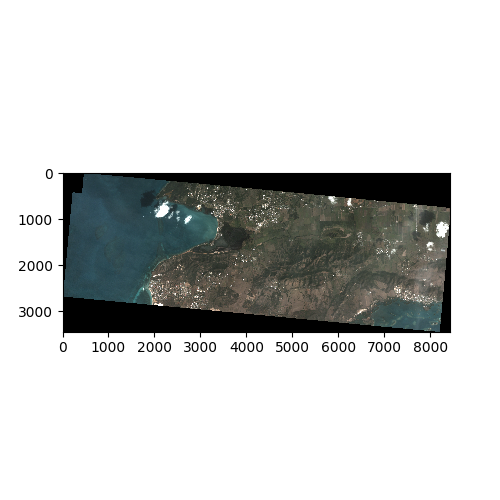

In [4]:
cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)


xstart = 1200
xlen = 256
ystart = 1300
ylen = 256

test_img = fixRGBimg(img.image,0,255/3000,0,255) # turn into 0-255
predict_size = 256
img.testimage = test_img[ystart:ystart+ylen,xstart:xstart+xlen,:]

fig = plt.figure(2, figsize=(5,5))
pic = np.rollaxis(np.asarray([img.testimage[:,:,2], img.testimage[:,:,1], img.testimage[:,:,0]]),0,3)
pic = np.asarray(pic, dtype=np.uint8)
plt.imshow(pic)
plt.show()

# print(pic[150,25])

In [61]:
jsonclasspath = './utils/CoralClasses.json'

with open(jsonclasspath) as json_file:
    json_classes = json.load(json_file)

labelkey = json_classes["VedConsolidated_ClassDict"]
class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v
print(class_indices_rev)

img.set_mean_std(100,100)
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    img.predict_on_whole_image(model, image_size = 256, num_classes = len(class_indices_rev), spacing = (256,256), predict_size = 256, num_lines=None, lastchannelremove=False)



{1: 'Coral', 2: 'Sediment', 3: 'Beach', 4: 'Seagrass', 5: 'Terrestrial vegetation', 6: 'Deep water', 7: 'Clouds', 8: 'Wave breaking', 9: 'Other or Unknown'}
Line: 0 Col: 0/ 1 completed


<IPython.core.display.Javascript object>


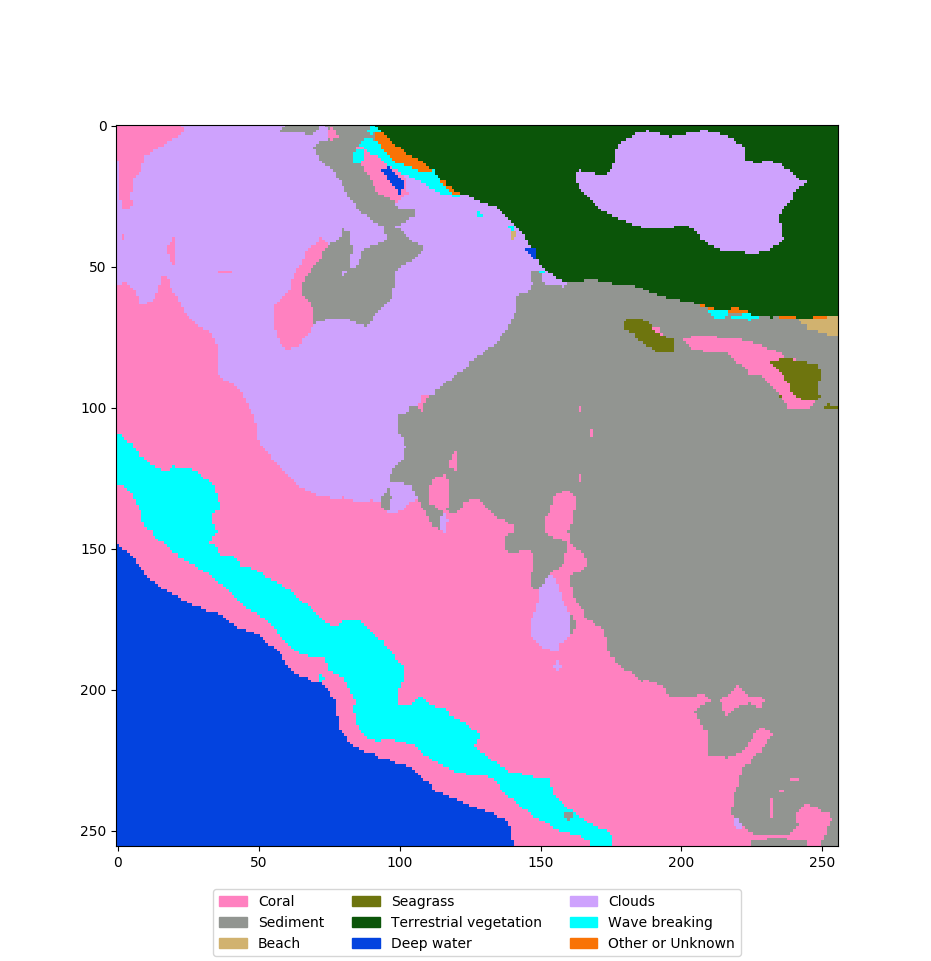

In [62]:
fig = plt.figure(3,figsize=(8,8))
plt.imshow(whole_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
plt.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
plt.show()



<IPython.core.display.Javascript object>


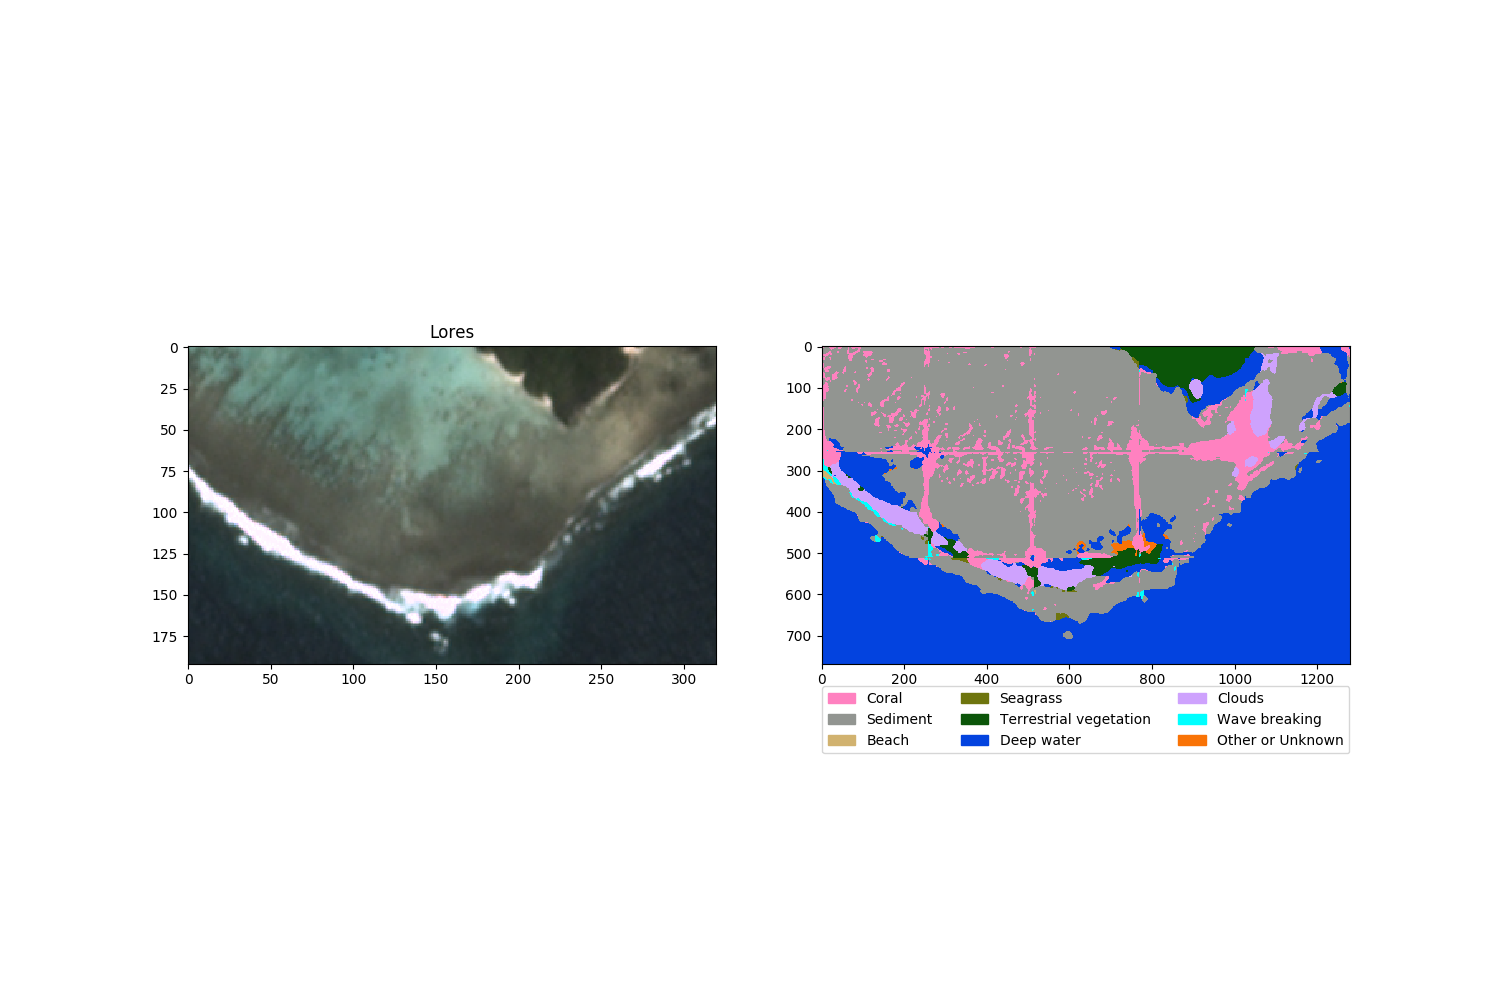

Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed


In [42]:
from keras.preprocessing.image import img_to_array
import keras.backend as K

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

ymin = 1500
xmin = 1400
rows = 3
cols = 5
l = 64
samplepatch_RGB = img.image[ymin:ymin+l*rows,xmin:xmin+l*cols,2::-1]
samplepatch_RGB = np.asarray(np.clip(255/3000*samplepatch_RGB,0,255), dtype=np.uint8)

fig = plt.figure(4, figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(samplepatch_RGB)
ax.set_title('Lores')

# Turn patch into standardized BGR + NIR
pixel_mean =1500
pixel_std = 1500
# samplepatch = np.dstack((img.image[ymin:ymin+l,xmin:xmin+l,0:3],img.image[ymin:ymin+l,xmin:xmin+l,-1])) #BGR+NIR


jsonclasspath = './utils/CoralClasses.json'

with open(jsonclasspath) as json_file:
    json_classes = json.load(json_file)

labelkey = json_classes["VedConsolidated_ClassDict"]
class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v

whole_imgpredict_fix = np.zeros((rows*l*4,cols*l*4,4), dtype=np.uint8)
whole_imgpredict = np.zeros((rows*l*4,cols*l*4), dtype=np.uint8)

for j in range(rows):
    for i in range(cols):
        samplepatch = img.image[ymin+j*l:ymin+(j+1)*l,xmin+i*l:xmin+(i+1)*l,:]
        samplepatch = img_to_array(samplepatch, data_format=K.image_data_format())
        samplepatch = (samplepatch-pixel_mean)/pixel_std

        imgbatch = np.expand_dims(samplepatch, axis=0)
        imgpredict = supermodel.predict(imgbatch, batch_size = 1)[0]
        kernel_sharpening = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        imgpredict_sharpen = np.zeros(imgpredict.shape)
        for k in range(4):
            imgpredict_sharpen[:,:,k] = cv2.filter2D(imgpredict[:,:,k], -1, kernel_sharpening)
#         imgpredict_sharpen = np.dstack((imgpredict_sharpen[:,:,2::-1],imgpredict_sharpen[:,:,-1])) #RGB+NIR
        imgpredict_sharpen = fixRGBimg(imgpredict_sharpen,100,100,0,255)
        
        predict_size = 256
        img.testimage = imgpredict_sharpen
        
        img.set_mean_std(140,105)
        whole_predict, num_predict, prob_predict, truth_predict, accuracy = img.predict_on_whole_image(model, image_size = 256, num_classes = len(class_indices_rev), spacing = (256,256), predict_size = 256, num_lines=None, lastchannelremove=False)
        whole_imgpredict[j*l*4:(j+1)*l*4, i*l*4:(i+1)*l*4] = whole_predict
#         imgpredict = fixRGBimg(imgpredict_sharpen,100,100,0,255)
#         imgpredict_fix = np.zeros((imgpredict.shape[0],imgpredict.shape[1],4))
#         imgpredict_fix[:,:,0] = imgpredict[:,:,2]
#         imgpredict_fix[:,:,1] = imgpredict[:,:,1]
#         imgpredict_fix[:,:,2] = imgpredict[:,:,0]
#         imgpredict_fix[:,:,3] = imgpredict[:,:,3]
#         imgpredict_fix = np.asarray(imgpredict_fix, dtype=np.uint8)
#         whole_imgpredict_fix[j*l*4:(j+1)*l*4, i*l*4:(i+1)*l*4,:] = imgpredict_fix

ax = plt.subplot(1,2,2)
plt.imshow(whole_imgpredict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
plt.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
plt.show()

# ax = plt.subplot(1,2,2)
# ax.imshow(whole_imgpredict_fix[:,:,:3])
# ax.set_title('SRx4')

<IPython.core.display.Javascript object>


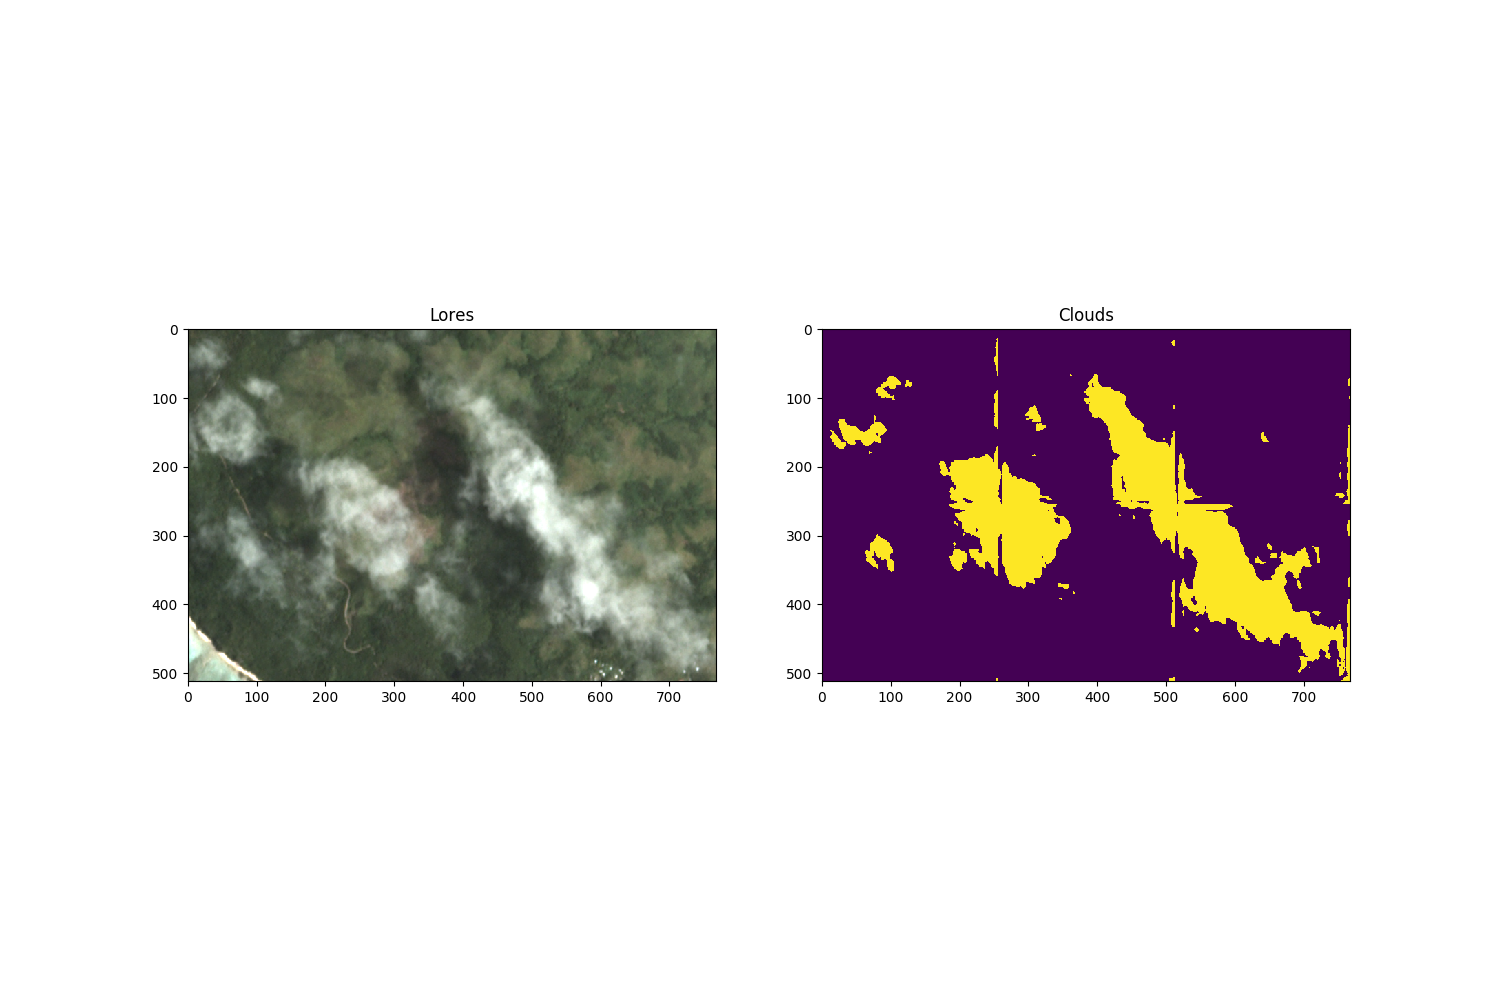

Text(0.5,1,'Clouds')

In [28]:
from keras.preprocessing.image import img_to_array
import keras.backend as K

ymin = 800
xmin = 1200
rows = 2
cols = 3
l = 256
samplepatch_RGB = img.image[ymin:ymin+l*rows,xmin:xmin+l*cols,2::-1]
samplepatch_RGB = np.asarray(np.clip(255/2000*samplepatch_RGB,0,255), dtype=np.uint8)

fig = plt.figure(5, figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(samplepatch_RGB)
ax.set_title('Lores')

# Turn patch into standardized BGR + NIR
pixel_mean = 500
pixel_std = 1000
# samplepatch = np.dstack((img.image[ymin:ymin+l,xmin:xmin+l,0:3],img.image[ymin:ymin+l,xmin:xmin+l,-1])) #BGR+NIR

whole_imgpredict_fix = np.zeros((rows*l,cols*l), dtype=np.uint8)

for j in range(rows):
    for i in range(cols):
        samplepatch = img.image[ymin+j*l:ymin+(j+1)*l,xmin+i*l:xmin+(i+1)*l,:]
#         samplepatch = np.dstack((img.image[ymin+j*l:ymin+(j+1)*l,xmin+i*l:xmin+(i+1)*l,2::-1],img.image[ymin+j*l:ymin+(j+1)*l,xmin+i*l:xmin+(i+1)*l,-1])) #BGR+NIR
        samplepatch = img_to_array(samplepatch, data_format=K.image_data_format())
        samplepatch = (samplepatch-pixel_mean)/pixel_std

        imgbatch = np.expand_dims(samplepatch, axis=0)
        imgpredict = Cloudmodel.predict(imgbatch, batch_size = 1)[0]
        imgpredict = np.argmax(imgpredict,-1)
        imgpredict_fix = imgpredict.reshape((l,l))

        # imgpredict_sharpen = np.dstack((imgpredict_sharpen[:,:,2::-1],imgpredict_sharpen[:,:,-1])) #RGB+NIR
        imgpredict_fix = np.asarray(imgpredict_fix, dtype=np.uint8)
        
        whole_imgpredict_fix[j*l:(j+1)*l, i*l:(i+1)*l] = imgpredict_fix

ax = plt.subplot(1,2,2)
ax.imshow(whole_imgpredict_fix[:,:])
ax.set_title('Clouds')